# Day 8 Exercises

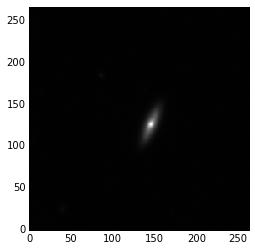

In [17]:
import numpy as np
import astropy.io.fits
from matplotlib import pyplot
%matplotlib inline

# you may have to change the path here in your own copy.
fits = astropy.io.fits.open("../../data/hsc-image-small.fits")
image = fits[0].data
variance = fits[1].data
detections = fits[2].data
pyplot.imshow(image, origin='lower', interpolation='nearest', cmap=pyplot.cm.gray, vmin=-0.1, vmax=1.0)

## 1. Elliptical Gaussians as Models

Earlier today we discussed the likelihood for fitting a model $f(n|\theta)$ to pixel data.  As our model, we'll use the same 2-d Gaussian we used yesterday as a weight function for moments.  Gaussians aren't particularly great models for representing astronomical sources, but they're not terrible, and they have some nice mathematical properties we'll make use of later.

In this context, what are the parameters $\theta$ of the Gaussian model?

variance and mean: moments m0, mx, my, mxx, myy, mxy

Write a new function that computes the negative log likelihood of the image data in `hsc-image-small.fits` for a Gaussian model, given the model parameters (as function arguments) and the variance image in that same file.  This function should call your function that just draws a Gaussian image from yesterday (which you can paste here, or you can put them into a module and `import` that module here).  For now, don't worry about the fact that the image contains more than one source,

In [26]:
def make_coordinate_arrays(shape):
    """
    Returns a meshgrid indexing coordinates given in shape.
    """
    dimensions = np.arange(shape[0]),np.arange(shape[1]) #y,x, 267 tall by 263 wide
    coord_mesh = np.meshgrid(dimensions[1],dimensions[0]) #x,y
    return coord_mesh

#image.shape == mesh[1].shape # Returns true
#mesh = make_coordinate_arrays(image.shape)

def gaussian_image(mesh,moments):
    m0,mx,my,mxx,myy,mxy = moments

    C = [[mxx,mxy],[mxy,myy]]
    Cinv = np.linalg.inv(C)

    x,y = mesh[0],mesh[1]
    matrix_product = (x-mx)**2*Cinv[0,0] + (y-my)**2*Cinv[1,1] + 2*(x-mx)*(y-my)*Cinv[0,1]

    gaussian = np.exp(-1/2*matrix_product)
    #gaussian = np.exp(-1./10000*(mesh[0]**2+mesh[1]**2)) # test gaussian of sigma 100
    gaussian /= gaussian.sum()
    gaussian *= m0
    #pyplot.imshow(gaussian, origin='lower', interpolation='nearest',)
    return gaussian

def neg_log_likelihood_gaussian(image,variance,moments,mask=None):
    if mask is None:
        mask = np.ones(image.shape)
    mesh = make_coordinate_arrays(image.shape)
    model = gaussian_image(mesh,moments)
    return 0.5*np.sum(mask*(image-model)**2/variance)

Use your step-function moments measurements from yesterday (or de-biased weighted moments) to make some educated guesses for the best-fit parameters $\theta$ for the brightest source (`detection==5`).  Evaluate your likelihood at that $\theta$, then choose one of the parameters (I recommend $m_x$ or $m_y$), modify it slightly in the neighborhood of your initial guess, and plot how the negative log likelihood changes as a function of that parameter (with all the other parameters held fixed at your initial guess).

[ 4098.88037109   144.74723262   125.75019614    54.91206828   157.01002277
    53.11421082]


763827.33357367862

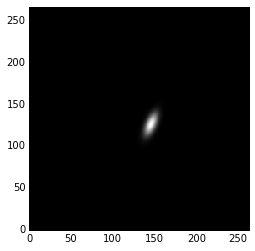

In [28]:
def weightedMoments(mesh,image,weight):
    """
    Computes the zeroth, first, and second moments of objects in the image
    given a weight image.
    """
    x,y = mesh[0],mesh[1]
    
    # Zeroth
    m0 = np.sum(image*weight)

    # First
    #x*image*(detections==5).sum()
    mx = 1/m0*np.sum(x*image*weight)
    my = 1/m0*np.sum(y*image*weight)

    # Second
    mxx = 1/m0*np.sum((x-mx)**2*image*weight)
    myy = 1/m0*np.sum((y-my)**2*image*weight)
    mxy = 1/m0*np.sum((x-mx)*(y-my)*image*weight)
    return np.array((m0,mx,my,mxx,myy,mxy))

momentsU5 = weightedMoments(make_coordinate_arrays(image.shape),image,detections==5)
print momentsU5
gaussian_img = gaussian_image(make_coordinate_arrays(image.shape),momentsU5)
pyplot.imshow(gaussian_img, origin='lower', interpolation='nearest', cmap=pyplot.cm.gray)

neg_log_likelihood_gaussian(image,variance,momentsU5,detections==5)

## 2. Specialized Least-Squares Fitters

Instead of writing our own fitting code today to explore the likelihood space, we'll use an existing one: [`scipy.optimize.leastsq`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.leastsq.html#scipy.optimize.leastsq).  This is a "greedy optimizer": it just tries to find the nearest local minimum in the function you give it as fast as it can.  It also requires the function we want to minimize to have a certain form - a sum of squares - which is exactly what we have.  Because it makes that assumption, it's less generally useful, but it's better at solving these sorts of problems than a more general optimizer, like [`scipy.optimize.minimize`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize).

Take a look at the documentation for `scipy.optimize.leastsq`, and write a function of the sort it expects as its `func` argument: this function will do most of the work of computing the likelihood of our Gaussian model, and `scipy.optimize.leastsq` will do the rest.

In [32]:
import scipy.optimize

def testfunc(x):
    return x
def residuals(moments,image,variance,mask=None):
    if mask is None:
        mask = np.ones(image.shape)
    mesh = make_coordinate_arrays(image.shape)
    model = gaussian_image(mesh,moments)
    return (mask*(image-model)/np.sqrt(variance)).flatten()


scipy.optimize.leastsq(residuals,momentsU5,args=(image,variance,detections==5))

(array([ 3716.2492402 ,   144.84210921,   125.72225552,    72.62512967,
          242.02609104,    89.03345483]), 1)

Try running the fitter on this problem, using the guesses you got from moments as the initial parameters.  Check that you get the same result from the fitter if you start it off with slightly different initial parameters.

In [33]:
scipy.optimize.leastsq(residuals,momentsU5*1.1,args=(image,variance,detections==5))

(array([ 3716.27222496,   144.84211091,   125.72225664,    72.62619337,
          242.03098245,    89.03529564]), 1)

## 3. PSF-Convolved Models

The data image we have is related to the true ideal image of the source by convolution with the PSF, so the model parameter we're fitting depend on both the true position and shape of the object *and* the shape of the PSF.  If we want our model parameters to not depend on the PSF the image was observed with, we need our model to represent the true sky, not the data image.

To do that, we can do the same thing to the model that the observation process has done to the ideal image: we can convolve it by the PSF.

We'll approximate the PSF for this image as another Gaussian with the following moments:

In [ ]:
psf_moments = {"mx": 0.0, "my": 0.0, "mxx": 3.9771548941134864, "myy": 3.8040164531742597, "mxy": -0.21695453484795038}

One of the nice features of Gaussian functions is that if you convolve a Gaussian with another Gaussian, the result is another Gaussian with $\mu=\mu_1 + \mu_2$ and $C = C_1 + C_2$ - that is, we just add the means and add the covariance matrices.

Modify your code to convolve the Gaussian model by the PSF before creating an image of it or computing its likelihood (just copy the functions and rewrite them here).

If we were to fit this model, how would we expect the best-fit parameters to change?

Taking that into account, how should we go from the moments measurements to initial parameters to start off our PSF-convolved fit?  What could go wrong with this formula?  Think about what the valid ranges for Gaussian parameters are.

## 4. Put it all together.

Write a function that takes a data image, a detection mask image, and the PSF moments, and then:
 - Computes step-function moments to guess an initial parameter.
 - Attempts to correct the initial parameters to account for the PSF, while making sure the parameters remain valid.
 - Runs `scipy.optimize.leastsq` with the PSF-convolved galaxy model.
 - Print a message if the fit failed.
 - Return the best-fit parameter vector.

Write a function that takes the data image and a parameter vector for your Gaussian model and plots three images:
 - the original data image
 - the model image
 - the difference between them
 
Hint: check out [`this matplotlib example`](http://matplotlib.org/examples/pylab_examples/subplot_demo.html) for how to display multiple images at once.

Use these two new functions to fit and display images for each of the three sources in the image.